In [1]:
import random
import time
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2 as cv
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

In [2]:
seed = 1
gymID = "HalfCheetah-v4"
nEnvs = 8
totalNSteps = 2000000
nStepsPerRollout = 1024
batchSize = int(nStepsPerRollout*nEnvs)
nMinibatches = 32
minibatchSize = int(batchSize // nMinibatches)
LearningRate = 3e-3
annealLR = True
gamma = 0.99
nUpdateEpochs = 10
clipCoefficient = 0.2
entropyLossCoefficient = 0.01
valueLossCoefficient = 0.5
maxGradNorm = 0.5
normAdvantages = True
gaeLambda = 0.95 # general advantage estimation
torch.set_printoptions(linewidth=120, precision=2, sci_mode=False, profile="short")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def saveVideo(images, outputDirectory, fps):
    height, width, _ = images[0].shape
    writer = cv.VideoWriter(outputDirectory, cv.VideoWriter_fourcc(*'H264'), fps, (width, height))
    for image in images:
        bgr_image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        writer.write(bgr_image)
    writer.release()

@torch.no_grad()
def recordVideoOfAgent(agent, environmentName, filename, fps=30):
    images = []
    environment = gym.make(environmentName, render_mode="rgb_array")
    for i in range(1):
        state, _ = environment.reset()
        totalReward = 0
        while True:
            action, _, _, _ = agent.get_action_and_value(torch.tensor(state).to(device))
            nextState, reward, terminated, truncated, _ = environment.step(action.cpu().numpy())
            nextState = torch.tensor(nextState, dtype=torch.float32)
            totalReward += reward
            images.append(environment.render())

            if terminated or truncated:
                print(f"Final reward: {totalReward:>8.2f}")
                break

            state = nextState
    saveVideo(images, f"{filename}-({totalReward:.0f}).mp4", fps)

def splitNumber(number, nSplits):
    step = number / (nSplits - 1)
    indices = [0]
    for i in range(1, nSplits - 1):
        indices.append(round(step * i))
    indices.append(number - 1)
    return indices

def linearInitialize(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super(Agent, self).__init__()
        self.critic = nn.Sequential(
            linearInitialize(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
            nn.Tanh(),
            linearInitialize(nn.Linear(256, 128)),
            nn.Tanh(),
            linearInitialize(nn.Linear(128, 64)),
            nn.Tanh(),
            linearInitialize(nn.Linear(64, 1), std=1.0))

        self.actorMean = nn.Sequential(
            linearInitialize(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
            nn.Tanh(),
            linearInitialize(nn.Linear(256, 128)),
            nn.Tanh(),
            linearInitialize(nn.Linear(128, 64)),
            nn.Tanh(),
            linearInitialize(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01))

        self.actorLogStd = nn.Parameter(torch.zeros(np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        x = x.to(torch.float32)
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        x = x.to(torch.float32)
        actionMean = self.actorMean(x)
        actionLogStd = self.actorLogStd.expand_as(actionMean)
        actionStd = torch.exp(actionLogStd)
        probabilities = Normal(actionMean, actionStd)
        if action is None:
            action = probabilities.sample()
        #print(f"probabilities.log_prob(action).shape = {probabilities.log_prob(action).shape}, probabilities.entropy().shape = {probabilities.entropy().shape}")
        return action, probabilities.log_prob(action).sum(-1), probabilities.entropy().sum(-1), self.critic(x)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

envs = gym.vector.make(gymID, num_envs=nEnvs)

agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=LearningRate, eps=1e-5)

obs = torch.zeros((nStepsPerRollout, nEnvs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((nStepsPerRollout, nEnvs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((nStepsPerRollout, nEnvs)).to(device)
rewards = torch.zeros((nStepsPerRollout, nEnvs)).to(device)
dones = torch.zeros((nStepsPerRollout, nEnvs)).to(device)
values = torch.zeros((nStepsPerRollout, nEnvs)).to(device)

globalStep = 0
startTime = time.time()
nextObs, _ = envs.reset(seed=seed)
nextObs = torch.tensor(nextObs).to(device)
nextDone = torch.zeros(nEnvs).to(device)
nUpdates = int(totalNSteps // batchSize)

totalEpisodicRewards = torch.zeros(nEnvs).to(device)

TypeError: RandomNumberGenerator._generator_ctor() takes from 0 to 1 positional arguments but 2 were given

In [107]:
allScores = []
for update in range(1, nUpdates + 1):
    if annealLR:
        frac = 1.0 - (update - 1.0) / nUpdates
        lrnow = frac * LearningRate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, nStepsPerRollout):
        globalStep += 1 * nEnvs
        obs[step] = nextObs
        dones[step] = nextDone
        
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(nextObs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob
        
        nextObs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        done = np.logical_or.reduce([terminated, truncated])
        rewards[step] = torch.tensor(reward).to(device)
        nextObs, nextDone = torch.Tensor(nextObs).to(device), torch.Tensor(done).to(device)
            
        totalEpisodicRewards += torch.tensor(reward).to(device)
        for finalScore in totalEpisodicRewards[done]:
            print(f"Score: {finalScore:>8.2f}")
            allScores.append(finalScore.item())
        totalEpisodicRewards[done] = 0

    with torch.no_grad():
        nextValue = agent.get_value(nextObs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(nStepsPerRollout)):
            if t == nStepsPerRollout - 1:
                nextnonterminal = 1.0 - nextDone
                nextvalues = nextValue
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gaeLambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    batchObs = obs.reshape((-1,) + envs.single_observation_space.shape)
    batchLogProbabilities = logprobs.reshape(-1)
    batchActions = actions.reshape((-1,) + envs.single_action_space.shape)
    batchAdvantages = advantages.reshape(-1)
    batchReturns = returns.reshape(-1)
    batchValues = values.reshape(-1)

    # Optimizing the policy and value network
    batchIndices = np.arange(batchSize)
    for epoch in range(nUpdateEpochs):
        np.random.shuffle(batchIndices)
        for start in range(0, batchSize, minibatchSize):
            end = start + minibatchSize
            miniBatchIndices = batchIndices[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(batchObs[miniBatchIndices], batchActions[miniBatchIndices])
            logratio = newlogprob - batchLogProbabilities[miniBatchIndices]
            ratio = logratio.exp()

            minibatchAdvantages = batchAdvantages[miniBatchIndices]
            if normAdvantages:
                minibatchAdvantages = (minibatchAdvantages - minibatchAdvantages.mean()) / (minibatchAdvantages.std() + 1e-8)

            # Policy loss
            policyLoss = -minibatchAdvantages * ratio
            policyLossClipped = -minibatchAdvantages * torch.clamp(ratio, 1 - clipCoefficient, 1 + clipCoefficient)
            policyLossFinal = torch.max(policyLoss, policyLossClipped).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            valueLossUnclipped = (newvalue - batchReturns[miniBatchIndices]) ** 2
            valueLossClipped = batchValues[miniBatchIndices] + torch.clamp(newvalue - batchValues[miniBatchIndices], -clipCoefficient, clipCoefficient)
            valueLossClipped = (valueLossClipped - batchReturns[miniBatchIndices]) ** 2
            valueLoss = torch.max(valueLossUnclipped, valueLossClipped)
            valueLoss = 0.5 * valueLoss.mean() # Supposedly 0.5 is to cancel out ** 2 and speed up backprop

            entropyLoss = entropy.mean()
            loss = policyLossFinal + valueLossCoefficient*valueLoss - entropyLossCoefficient*entropyLoss
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), maxGradNorm)
            optimizer.step()
    
    if update in splitNumber(nUpdates, 10) or update == nUpdates or update == 1:
        recordVideoOfAgent(agent, gymID, f"videos/{gymID}-{globalStep/1000:.0f}k")

Score:   613.65
Score:   790.80
Score:   529.52
Score:   661.69
Score:   461.92
Score:   448.15
Score:   586.57
Score:   669.22


C:\Users\Inexperienced Me\AppData\Local\Temp\ipykernel_61632\2914820925.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action, _, _, _ = agent.get_action_and_value(torch.tensor(state).to(device))


Final reward:  -584.41
Score:   527.00
Score:   533.37
Score:   328.76
Score:   426.56
Score:   420.88
Score:   421.92
Score:   486.31
Score:   528.28
Score:  -522.62
Score:  -655.16
Score:  -570.10
Score:  -624.27
Score:  -430.10
Score:  -554.92
Score:  -545.85
Score:  -540.26
Score:  -629.64
Score:  -585.92
Score:  -738.70
Score:  -636.58
Score:  -719.37
Score:  -613.72
Score:  -749.48
Score:  -710.72
Score:  -563.37
Score:  -573.86
Score:  -522.29
Score:  -521.87
Score:  -583.95
Score:  -527.86
Score:  -641.03
Score:  -585.35
Score:  -553.94
Score:  -581.88
Score:  -390.69
Score:  -557.28
Score:  -514.31
Score:  -570.86
Score:  -547.44
Score:  -565.54
Score:  -622.36
Score:  -680.68
Score:  -673.13
Score:  -650.80
Score:  -635.81
Score:  -639.37
Score:  -495.28
Score:  -669.36
Score:  -579.12
Score:  -604.74
Score:  -689.00
Score:  -482.34
Score:  -636.16
Score:  -747.54
Score:  -687.05
Score:  -613.86
Score:  -651.17
Score:  -651.46
Score:  -525.14
Score:  -542.58
Score:  -517.33
S

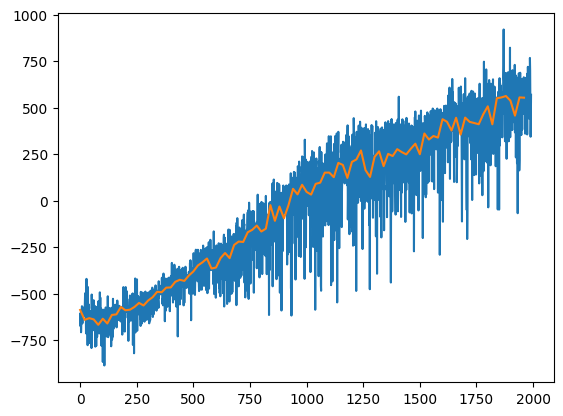

In [106]:

def movingAveragePlot(values, averagingValue):
    plt.plot(range(len(values)), values, label="scores")
    plt.plot([i*averagingValue for i in range(len(values)//averagingValue)], torch.tensor(values[len(values)%averagingValue:]).view(-1, averagingValue).mean(1), label=f"averaged {averagingValue}")

movingAveragePlot(allScores, 20)

